# GAN - first tries

We are implementing a simple feed-forward GAN architecture on MNIST - just to get the feeling right.

## Loading data

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [2]:
(train_data,_),(test_data,_) = mnist.load_data()

In [3]:
# The more the merrier :-)
# Remember, this is unsupervised learning, so "holdout" and such makes less sense
data = np.concatenate((train_data,test_data),axis=0)

In [4]:
data.shape

(70000, 28, 28)

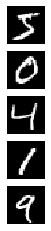

In [5]:
import matplotlib.pyplot as plt

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex], interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

In [6]:
# Normalization betwenn -1 and 1 !!!!
quasi_mean = data.max()/2 # Max is always 255, so this works ok.
data = (data.astype(np.float32)-quasi_mean)/quasi_mean

In [7]:
# Flattening of the image vectors
data = data.reshape(data.shape[0],-1)
data.shape

(70000, 784)

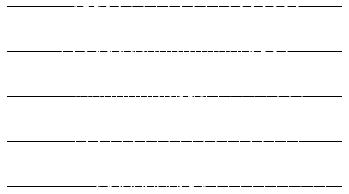

In [8]:
# Just to get the feeling, how bad this representation is...

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex].reshape(1,-1), interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

## Parameters

### Training parameters

We will be forced to do manual batching here, so we have to calcculate the number of batches manually, and iterate on a per batch basis.

In [9]:
EPOCHS = 30

# for training the generator (discriminator freezed)
BATCH_SIZE = 200

# for training discriminator (generator freezed)
HALF_BATCH = BATCH_SIZE // 2  #100

# number of batches we have for trainig (must be integer)
BATCH_NUM = (data.shape[0] // BATCH_SIZE)

if data.shape[0] % BATCH_SIZE:
    BATCH_NUM+=1

# size of the noise vector
Z_DIM = 100


### Model parameters

In [10]:
GENERATOR_L1_DIM = 256
GENERATOR_L2_DIM = 512
GENERATOR_L3_DIM = 1024

DISCRIMINATOR_L1_DIM = 512
DISCRIMINATOR_L2_DIM = 256

LEAKY_ALPHA = 0.2

## Model building

In [11]:
from tensorflow.keras.optimizers import Adam

# Some empirically set values. 
# It might well be worth experimenting with newer optimizers / settings
optimizer = Adam(lr=2e-4, beta_1=0.5)

### Generator

In [12]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model

In [13]:
### Define the generator!
#########################

# We use FUNCTIONAL API!

# The generator always gets a noise vector as input
noise_input = Input(shape=(Z_DIM, ))

# Define the first layer of the fully connected network, without activation!
# Use the parameters defined with capital letter constants in the cells above for node counts!
g_layer_1 = Dense(GENERATOR_L1_DIM, activation=None)(noise_input)
# Define a non-linearioty, namely leaky relu on this layer!
# We use LeakyReLU for avoiding sparsity - other options are viable also, just not normal relu
# Use the alpha value defined in constants above!
g_layer_1_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_1)
# You can do this as one layer, but now we do it in two. Does not matter.

# Repeat the process two more times!
g_layer_2 = Dense(GENERATOR_L2_DIM, activation=None)(g_layer_1_nonlin)
g_layer_2_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_2)

g_layer_3 = Dense(GENERATOR_L3_DIM, activation=None)(g_layer_2_nonlin)
g_layer_3_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_3)

# The output of the generator is a flattened image
# Remeber, we normalized everything between -1 and +1, so what is a nice nonlinearity, bounded between
# -1 and 1? 
# Use that one as an activation for the final fully connected layer!
g_output_layer = Dense(data.shape[1], activation='tanh')(g_layer_3_nonlin)

# Please instantiate the model!
generator = Model(inputs=noise_input, outputs=g_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
# Think about this carefully, please!

### Discriminator

In [14]:
### Define the discriminator!
#############################

# We still use FUNCTIONAL API!

# The discriminator always gets (flattened) images as inputs
# Where can you find the flattened dimensions? 
# Please use a variable or property, not a hand "baked in" constant.
# That will mess up your life if the data changes...
image_input = Input(shape=(data.shape[1], ))

# Following the design pattern from above, please implement two layers with nonlinearities!
d_layer_1 = Dense(DISCRIMINATOR_L1_DIM, activation=None)(image_input)
d_layer_1_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_1)


d_layer_2 = Dense(DISCRIMINATOR_L2_DIM, activation=None)(d_layer_1_nonlin)
d_layer_2_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_2)


# Please implement the output layer!
# The output of the discriminator is a single binary decision, 
# so one use an appropriate activation and dimensionality!
d_output_layer = Dense(1, activation='sigmoid')(d_layer_2_nonlin)

# Please instantiate the model!
discriminator = Model(inputs=image_input, outputs=d_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

### Joint model

In [15]:
### Define the GAN itself!
##########################


# STOP!!!!!!
# This is a crucial line, since in the joint model, discriminator will be frozen, so no weight update!
discriminator.trainable = False

################################## EXPLANATION #####################################
# yes when we train the generator the discriminator is frozen,
# otherwise the weights of the discrimator will be updated in such a way that
# it gets better at fooling it self as a result the discrinator will start giving
# the poor quality generated images as original images and we wont be haiving any error
# to have backpropagation. Additionally, It would be a complete mess if we then freez the 
# generator and update discrimnator's weights on real and fake data. 



# What is the input for the whole GAN?
# Think about the case, when the generator generates, the discriminator only discriminates it's output!
gan_input = Input(shape=(Z_DIM, ))

# Use the generator as a function on the input!
generated_image = generator(gan_input)

# Use the discriminator as a function on the fake images!
gan_output = discriminator(generated_image)

# Instantiate the joint model, appropriate input and output!
joint_model = Model(inputs=gan_input, outputs=gan_output)

# Please think about, why it can be true, that for the joint model a binary decision is still adequate!
joint_model.compile(loss='binary_crossentropy', optimizer=optimizer)

############################# EXPLANATION #######################################
# generator will generate fake images, these fake images goes into discriminator
# that outputs a probability of it being original(a low probability in initial training phase as
# generated images are of poor quality)
# we give the genrated fake images a true label=1, fooling the discriminator and to 
# create an error for backprop. This error is calulated on the basis of true label 
# which is 1 (convincing_y) and output of discriminator which hope fully is between 0 & 1 inclusive.
# It is now a binary classification problem for the whole GAN. 
# cost function for single example: -(y_true . log(D(G(z))))

# Maybe it will get clear below in the training loop...

## Helper functions for visualization

In [16]:
# Nothing to see here! :-P

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


def get_example_images(epoch, example_count=25):
    input_noise = np.random.normal(0,1, size=(example_count,Z_DIM))
    generated_images = generator.predict(input_noise)
    generated_images = generated_images.reshape(example_count, 28, 28)
    
    plt.figure(figsize = (5, example_count // 5))
    for ex in range(example_count):
        plt.subplot(5, example_count//5, ex+1)
        plt.imshow(generated_images[ex], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("example_images_epoch_num_{0}.png".format(epoch))

def show_image_for_epoch(epoch):
    imgname = "example_images_epoch_num_"+str(epoch)+".png"
    img = mpimg.imread(imgname)
    imgplot = plt.imshow(img)
    plt.show()


## Training

Sadly, we can not use simple `fit()`, but have to construct the main training loop ourselves.

100%|██████████| 350/350 [00:49<00:00,  7.02it/s]


Epoch number: 0 discriminator_loss: 0.6649539460454669 generator_loss: 0.9420809881176267


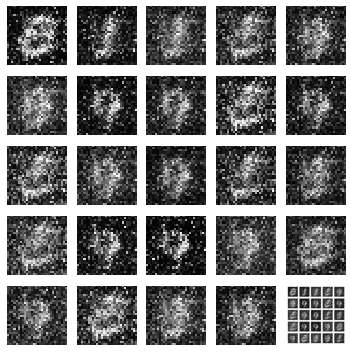

100%|██████████| 350/350 [00:47<00:00,  7.30it/s]


Epoch number: 1 discriminator_loss: 0.6283617751938956 generator_loss: 1.099129787002291


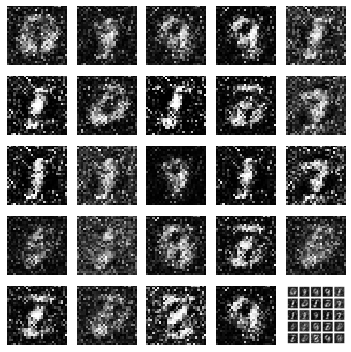

100%|██████████| 350/350 [00:47<00:00,  7.34it/s]


Epoch number: 2 discriminator_loss: 0.6123800254293851 generator_loss: 1.1782635600226266


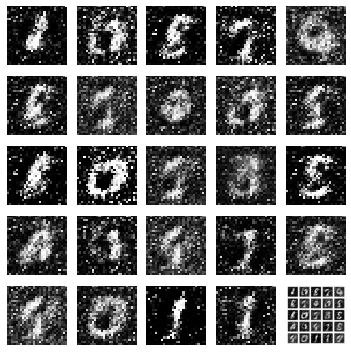

100%|██████████| 350/350 [00:47<00:00,  7.42it/s]


Epoch number: 3 discriminator_loss: 0.5975388463480132 generator_loss: 1.2260916941506521


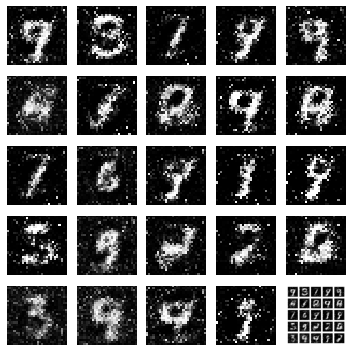

100%|██████████| 350/350 [00:47<00:00,  7.42it/s]


Epoch number: 4 discriminator_loss: 0.5943885748726981 generator_loss: 1.2108199964250836


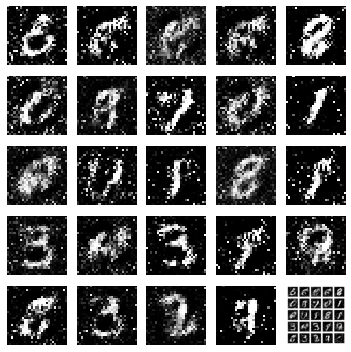

100%|██████████| 350/350 [00:48<00:00,  7.21it/s]


Epoch number: 5 discriminator_loss: 0.5862964820861817 generator_loss: 1.2159716316631861


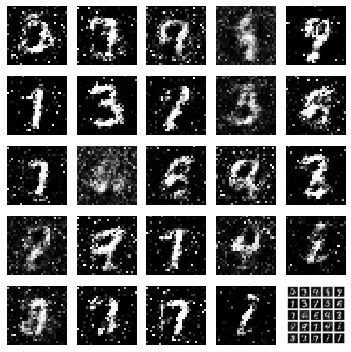

100%|██████████| 350/350 [00:46<00:00,  7.48it/s]


Epoch number: 6 discriminator_loss: 0.6106845879129001 generator_loss: 1.143328709261758


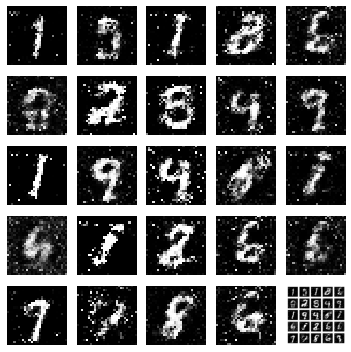

100%|██████████| 350/350 [00:47<00:00,  7.35it/s]


Epoch number: 7 discriminator_loss: 0.628139007304396 generator_loss: 1.0881716205392564


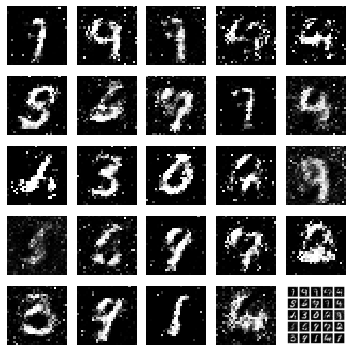

100%|██████████| 350/350 [00:47<00:00,  7.44it/s]


Epoch number: 8 discriminator_loss: 0.6366540929249355 generator_loss: 1.0578797236510686


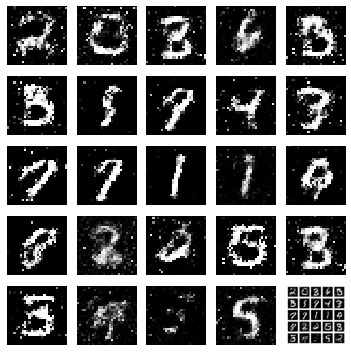

100%|██████████| 350/350 [00:46<00:00,  7.47it/s]


Epoch number: 9 discriminator_loss: 0.6440081750920841 generator_loss: 1.0292261028289795


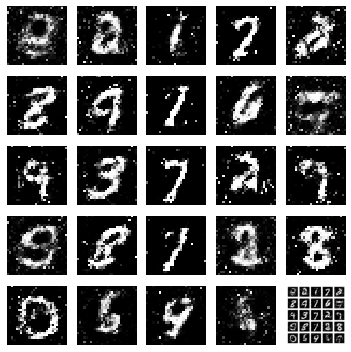

100%|██████████| 350/350 [00:46<00:00,  7.45it/s]


Epoch number: 10 discriminator_loss: 0.6481624861274446 generator_loss: 1.0133697881017412


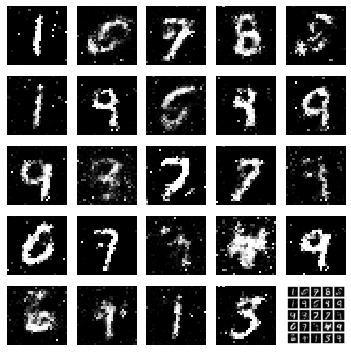

100%|██████████| 350/350 [00:47<00:00,  7.30it/s]


Epoch number: 11 discriminator_loss: 0.6455721691676548 generator_loss: 1.0285680333205631


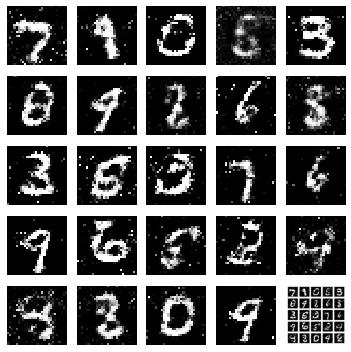

100%|██████████| 350/350 [00:47<00:00,  7.34it/s]


Epoch number: 12 discriminator_loss: 0.6421704394476754 generator_loss: 1.0396019984994616


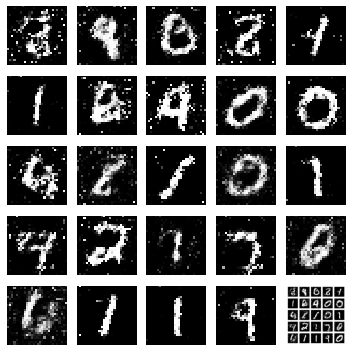

100%|██████████| 350/350 [00:47<00:00,  7.39it/s]


Epoch number: 13 discriminator_loss: 0.6446283069678715 generator_loss: 1.0342005005904606


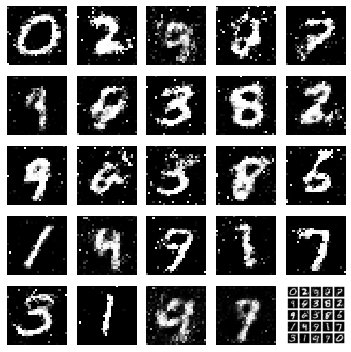

100%|██████████| 350/350 [00:47<00:00,  7.39it/s]


Epoch number: 14 discriminator_loss: 0.6481968922274454 generator_loss: 1.025003137588501


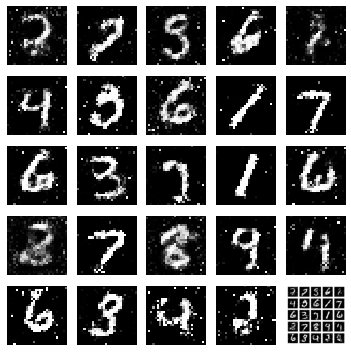

100%|██████████| 350/350 [00:47<00:00,  7.36it/s]


Epoch number: 15 discriminator_loss: 0.6524416138444628 generator_loss: 1.0207014099189213


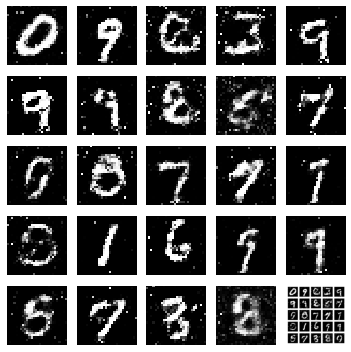

100%|██████████| 350/350 [00:46<00:00,  7.45it/s]


Epoch number: 16 discriminator_loss: 0.6527921540396554 generator_loss: 1.0167509915147508


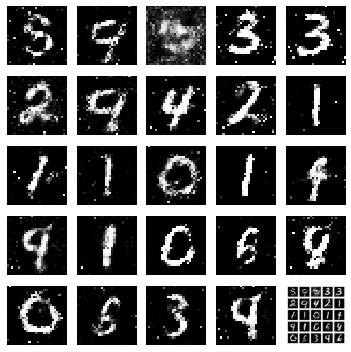

100%|██████████| 350/350 [00:47<00:00,  7.33it/s]


Epoch number: 17 discriminator_loss: 0.6543669269340379 generator_loss: 1.0109217868532454


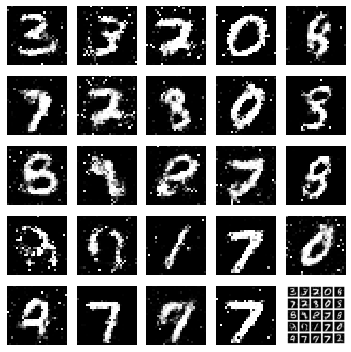

100%|██████████| 350/350 [00:46<00:00,  7.45it/s]


Epoch number: 18 discriminator_loss: 0.6547753934349333 generator_loss: 1.0077077550547464


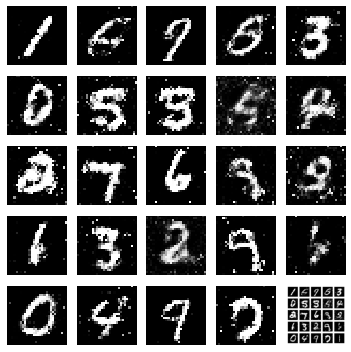

100%|██████████| 350/350 [00:47<00:00,  7.44it/s]


Epoch number: 19 discriminator_loss: 0.6545292374491691 generator_loss: 1.012960465465273


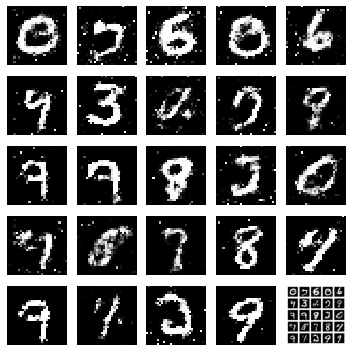

100%|██████████| 350/350 [00:47<00:00,  7.45it/s]


Epoch number: 20 discriminator_loss: 0.6577888026407787 generator_loss: 1.0061708894797734


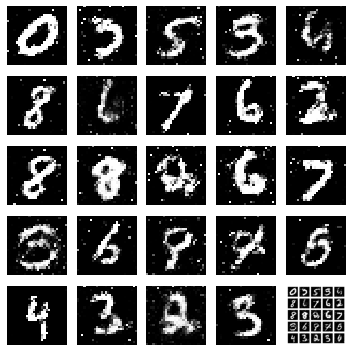

100%|██████████| 350/350 [00:47<00:00,  7.41it/s]


Epoch number: 21 discriminator_loss: 0.6575300076178142 generator_loss: 1.0058872166701724


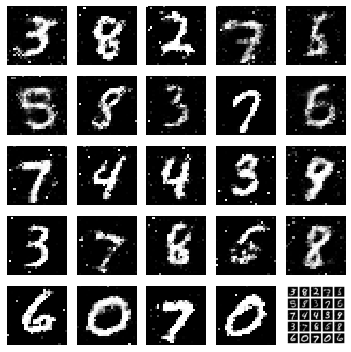

100%|██████████| 350/350 [00:46<00:00,  7.46it/s]


Epoch number: 22 discriminator_loss: 0.6572330784797669 generator_loss: 1.0106107326916285


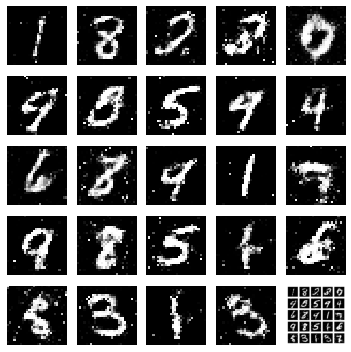

100%|██████████| 350/350 [00:47<00:00,  7.32it/s]


Epoch number: 23 discriminator_loss: 0.6581421196460724 generator_loss: 1.0063816615513392


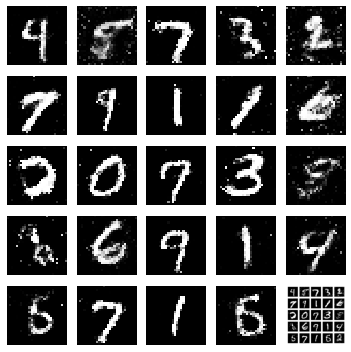

100%|██████████| 350/350 [00:48<00:00,  7.28it/s]


Epoch number: 24 discriminator_loss: 0.6572184931806155 generator_loss: 1.0104468934876578


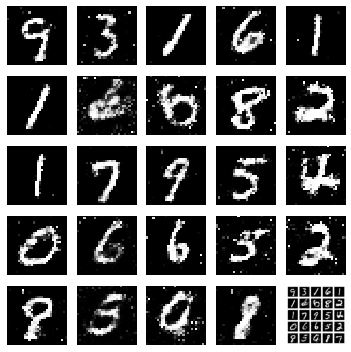

100%|██████████| 350/350 [00:47<00:00,  7.32it/s]


Epoch number: 25 discriminator_loss: 0.6566446428639549 generator_loss: 1.0091877601827894


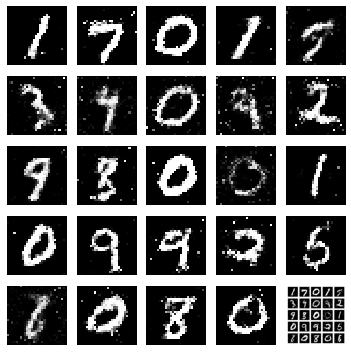

100%|██████████| 350/350 [00:48<00:00,  7.28it/s]


Epoch number: 26 discriminator_loss: 0.6600773104599544 generator_loss: 1.0019808983802796


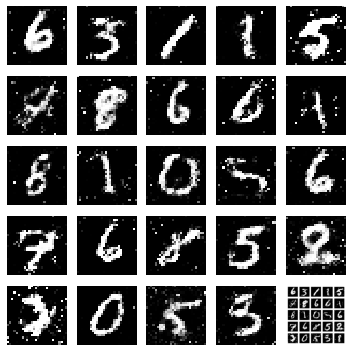

100%|██████████| 350/350 [00:48<00:00,  7.23it/s]


Epoch number: 27 discriminator_loss: 0.6609914537838527 generator_loss: 1.0010402699879237


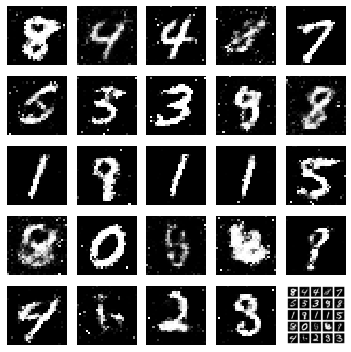

100%|██████████| 350/350 [00:48<00:00,  7.26it/s]


Epoch number: 28 discriminator_loss: 0.6618614312580654 generator_loss: 1.0094154684884207


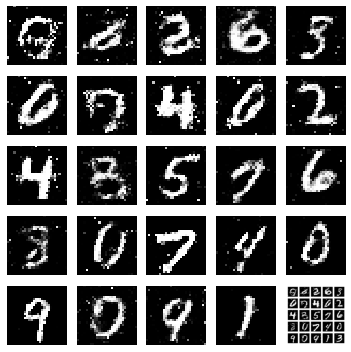

100%|██████████| 350/350 [00:49<00:00,  7.03it/s]


Epoch number: 29 discriminator_loss: 0.6605076941422053 generator_loss: 1.0103201702662876


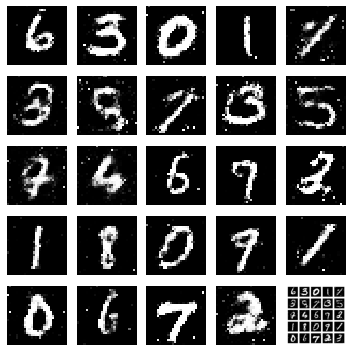

In [17]:
# To see some progress, we use tqdm as a progress bar
from tqdm import tqdm

# Since we do NOT use fit
# sadly, we have to do this ourselves manually
history = {"discriminator":[],"generator":[]}

# Main training loop
for epoch_num in range(EPOCHS):
    epoch_discriminator_loss = 0
    epoch_generator_loss = 0
    
    for batch in tqdm(range(BATCH_NUM)): # 350 batches in total 
        # We select randomly a half batch amount of real images from MNIST
        # Use Numpy to choose, no replacement!
        real_images = data[np.random.choice(range(0, data.shape[0]), size=HALF_BATCH, replace=False)]
        
        # We generate a half batch amount of fake images
        # By first generating a half batch worth of Gaussian noise with zero mean, unit variance
        # and appropriate noise dimensions
        input_noise = np.random.randn(HALF_BATCH, Z_DIM)
        # And then using the fixed generator, to output some images from it
        # Using the predict method of the generator!
        generated_images = generator.predict(input_noise)
        
        ############################### EXPLANATION ###################################
        # As of now, we only have a a half batch worth of Gaussian noise, we need generated images for
        # training the discriminator (when generator is freezed, only fwd. pass through generator)
        
        
        
        # We generate our "labels"
        # Remember one sided label smoothing for the positive class!
        # Let's say with 0.9...
        # So please, generate a half batch sized, one dimensional matrix with ones, using numpy
        # and multiuply it by 0.9
        real_y = np.ones(HALF_BATCH)*0.9
        # And generate a half batch worth of zeroes, again one dimensional matrix
        generated_y = np.zeros(HALF_BATCH)

        
        ### We do the actual training!
        
        # First for the discriminator on the real data
        discriminator_loss_real = discriminator.train_on_batch(real_images, real_y)
        
        # Then on the fake data
        discriminator_loss_generated = discriminator.train_on_batch(generated_images, generated_y)
        
        # Then average the two losses
        discriminator_loss = (discriminator_loss_real + discriminator_loss_generated) / 2
        epoch_discriminator_loss += discriminator_loss
        
        ### We then update the generator
        # We use the discriminator that was trained a line above, and is frozen, as defined in the joint model
        
        # Please generate a new set of input noise, notice, it is a full batch!
        # Again, using numpy, normal distribution, zero mean, unit variance
        new_input_noise = np.random.randn(BATCH_SIZE, Z_DIM)
        
        # We try to convince the discriminator, that this is real data - which is not
        # So please generate a batch worht of one dimensional matrix filled with ones 
        convincing_y = np.ones(BATCH_SIZE)
        # Notice, no label smoothing!

        # Remember, the joint model takes in noise, does the generation, the discrimination, then computes loss
        # But the discriminator is frozen, so only the generator will get updated
        # It is "successful" if the discriminator predicts "real" - hence the convincing_y
        generator_loss = joint_model.train_on_batch(new_input_noise, convincing_y)
        epoch_generator_loss += generator_loss
        
    # Loss printout in every epoch, averaged over the batches
    print("Epoch number:",epoch_num,"discriminator_loss:",epoch_discriminator_loss / BATCH_NUM, "generator_loss:", epoch_generator_loss / BATCH_NUM)
    
    # Save it for the future
    history["discriminator"].append(epoch_discriminator_loss / BATCH_NUM)
    history["generator"].append(epoch_generator_loss / BATCH_NUM)
    
    #Save model - optional
    #generator.save("generator.h5")
    
    #Save images
    get_example_images(epoch_num)
    
    # Show epoch example
    show_image_for_epoch(epoch_num)

## Visualization of training progress

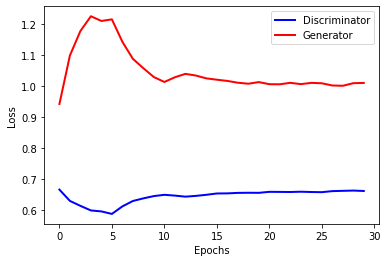

In [18]:
plt.plot(history["discriminator"], color='blue', linewidth=2, label="Discriminator")
plt.plot(history["generator"],  color='red', linewidth=2, label="Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();


I can see no sign of Mode Collapse as Discriminator loss is not constantly zero and Generator loss is not fluctiuating and is consistant. Generator is generating images with different numbers. 

Appearently, non-convergence doesnt seem to be a problem here. Discriminator error is increasing as generator error is decreasing and maintaining equlibrium. Generator seems to be learning the dirstribution of MNIST as it's loss is decreasing and discriminator's loss is increasing.  